# Setting up `photoeccentric` sensitivitiy tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [3]:
muirhead_data = pd.read_csv("/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


## Outline for Sensitivity Test

1. Define "test planet" parameters. These parameters will come from a real Kepler planet, but I'll use a fake light curve. These "test planet" parameters will stay the same across the entire test.
2. Write two functions: one that wraps the entire light curve initialization process, and one that wraps the transit fit and eccentricity estimation.
3. For each eccentricity recovered, take the difference between the input e and the peak of the e distribution as the error.
4. Plot on a heatmap

#### Defining a "test planet"

In [4]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

#iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from lagging)
#iso_lums.to_csv("feb19_21_iso_lums_" + str(kepid) + ".csv")

In [5]:
isodf = pd.read_csv(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/feb19_21_iso_lums_' + str(kepid) + '.csv')

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err)

In [6]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


###### Density of this star based on Gaia and spectroscopy:

In [7]:
def get_a_rs(rhos, periods):
    
    """Periods: days
    Rhos: kg/m^3"""
    
    a_rs = np.zeros(len(rhos))
    
    for i in range(len(rhos)):
        per_iter = periods[i]*86400
        rho_iter = rhos[i]
        
        a_rs[i] = ((per_iter**2)*((c.G*rho_iter)/(3*np.pi)))**(1.0/3.0)
        
    return a_rs

In [8]:
rhos_gaia = np.genfromtxt(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/jan29_21_rhos_5868793.0.csv', delimiter=',')

print('Mean density: ', np.mean(rhos_gaia))


Mean density:  28680.804526515014


A_rs prior:

In [9]:
pdist = np.random.normal(period, np.mean((abs(period_uerr), abs(period_lerr))), len(rhos_gaia))

In [10]:
a_rs_gaia = get_a_rs(rhos_gaia, pdist)

In [11]:
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)

In [12]:
a_rs_guess = np.mean(a_rs_gaia)
a_rs_priors = [a_rs_guess-10*np.std(a_rs_gaia), a_rs_guess+10*np.std(a_rs_gaia)]

In [13]:
a_rs_priors

[13.889022436260717, 51.618267026746835]

In [14]:
a_rs_guess

32.753644731503776

###### Creating a transit

In [15]:
def planetlc(time, per, rp, a, e, inc, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = e
    params.w = w                          #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    #params.limb_dark = "quadratic"
    #params.u = [0.1, 0.3]
    params.limb_dark = "uniform"
    params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [16]:
def photo_init(time, per, rp, a, e, inc, w):
    
    # Calculate flux from transit model
    flux = planetlc(time, period, rprs, a_rs, e, i, w)

    # Adding some gaussian noise
    noise = np.random.normal(0,0.000005,len(time))
    nflux = flux+noise
    
    flux_err = np.array([0.00005]*len(nflux))
    
    return nflux, flux_err

In [17]:
def chisqfunc(params, time, nflux, flux_err):
    per, rp, a, inc, w = params
    mod_flux = ph.planetlc_fitter(time, per, rp, a, inc, w)
    chisq = np.sum(((nflux - mod_flux)/flux_err)**2)
    return chisq

In [18]:
def log_likelihood(theta, time, flux, flux_err):
    """Log of likelihood
    model = ph.planetlc_fitter()
    gerr = sigma of g distribution
    """
    per, rp, a, inc = theta
    model = ph.planetlc_fitter(time, per, rp, a, inc, 0.0)
    sigma2 = flux_err ** 2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    """Log of prior
    e between 0 and 1
    w between -90 and 300
    """
    per, rp, a, inc = theta
    if 0.0 < rp < 1.0 and 0.0 < inc < 90.0:
        return 0.0
    return -np.inf

def log_probability(theta, time, flux, flux_err):
    """Log of probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, flux_err)


In [19]:
def mcmc_fitter(p0, time, nflux, flux_err, nsteps, e, w, directory, plot=True):
    
    solnx = (p0[0], p0[1], p0[2], p0[3])
    pos = solnx + 1e-4 * np.random.randn(64, 4)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, nflux, flux_err), threads=4)
    sampler.run_mcmc(pos, nsteps, progress=True);
    samples = sampler.get_chain()
    
    if plot==True:
        fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
        labels = ["period", "rprs", "a/Rs", "i"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number");
        print('hi')
        fig.savefig(directory + 'lcfit_burnin.png')
        plt.close(fig)
    
    flat_samples = sampler.get_chain(discard=4000, thin=15, flat=True)
    
    fig = corner.corner(flat_samples, labels=labels);
    fig.savefig('transit_corner.png')
    plt.close(fig)

    results = []
    for i in range(ndim):
        results.append(np.percentile(flat_samples[:,i], 50))

    return results[0], results[1], results[2], results[3]

In [20]:
# time = np.linspace(-24, 24, 10000)

# flux, flux_err = photo_init(time, period, rprs, a_rs, 0.0, i, 90.0)

# p0 = np.array([4.8, 0.036066, 35.0945803495, 89.9, 0.0])

# p, r, a, ie, w = mcmc_fitter(p0, time, flux, flux_err, 100)
# #fsamp = mcmc_fitter(p0, time, flux, flux_err, 100)

In [21]:
def dfdt(time, flux):
    """Returns T14 and T23 from derivative of transit fit."""
    
    ttime = time[4970:5030]
    tflux = flux[4970:5030]
    
    diffs = np.append(np.diff(tflux)/np.diff(ttime), 0)
    
    notzeros = np.where(tflux < 0.99985)[0]
    
    T14 = ttime[notzeros[-1]+1]-ttime[notzeros[0]-1]
    T23 = ttime[np.argmax(diffs)]-ttime[np.argmin(diffs)+1]
    
    return T14, T23

In [31]:
# def get_a_from_T14(T14, P, inc, rprs):
    
#     d2r = np.pi/180.0
    
#     b = a_rs*np.cos(i*d2r)
    
#     a_rs = 1.0/(np.sin((np.pi*T14)/P)*(np.sin(inc*d2r)/np.sqrt((1+rprs)**2)-b**2))
    
#     return a_rs
    

In [32]:
# get_a_from_T14(t14, period, i, rprs)

In [23]:
def photo_fit(time, nflux, flux_err, rho_star, e, w, directory, nsteps=1000, plot_transit=True, plot_burnin=True, fitter="MCMC"):
    
    mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
    periodogram = mod.autopower(0.2, objective="snr")
    per_guess = np.asarray(periodogram.period)[int(np.median(np.argmax(periodogram.power)))]
    
    # Guess T14 and T23 from derivative
    
    # Inital guess: period, rprs, a/Rs, i, w
    p0 = np.array([per_guess, 0.036066, a_rs_guess, 89.9, 90.0])
    #p0 = np.array([per_guess, 0.036066, 45, 89.9, 0.0])

    
    if fitter=="MCMC":
        # EMCEE Transit Model Fitting
        p_f, rprs_f, a_f, i_f = mcmc_fitter(p0, time, nflux, flux_err, nsteps, e, w, directory, plot=plot_burnin)
        
        perr_f = 0.001 #days to seconds
        rprserr_f = 0.001
    
    elif fitter!="MCMC":
        result =  opt.minimize(chisqfunc, p0, args=(time, nflux, flux_err), method=fitter)
    
        # Defining variables based on the fit parameters
        p_f = result.x[0] #days to seconds
        perr_f = 0.001 #days to seconds
        rprs_f = result.x[1]
        rprserr_f = 0.001
        a_f = result.x[2]
        i_f = result.x[3] 
        w_f = result.x[4]
        
    else:
        "You have to specify a fitting method"

    # Create a light curve with the fit parameters
    fit = ph.planetlc_fitter(time, p_f, rprs_f, a_f, i_f, 0.0)
    
    if plot_transit==True:
        plt.cla()
        plt.plot(time, nflux, c='blue', alpha=0.5, label='Original LC')
        plt.plot(time, fit, c='red', alpha=1.0, label='Fit LC')
        plt.xlim(-0.1, 0.1)
        plt.legend()
        
        plt.savefig(directory + 'lightcurve_fitp' + str(p_f) + '_fitrprs' + str(rprs_f) + '_fitars' + str(a_f) + '_fiti' + str(i_f) + '.png')
        plt.close()
            
    print('Fit params:')
    print('Period (days): ', p_f, 'Rp/Rs: ', rprs_f)
    print('a/Rs: ', a_f)
    print('i (deg): ', i_f)
        
        
    T14 = ph.get_T14(p_f*86400, rprs_f, a_f, i_f)
    T14err = 0.0001*86400 #I'm assuming a T14 error here

    T23 = ph.get_T23(p_f*86400, rprs_f, a_f, i_f)
    T23err = 0.0001*86400 #I'm assuming a T23 error here

    #gs, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f*86400, perr_f*86400, rprs_f, rprserr_f, T14, T14err, T23, T23err)

    gs, rho_c, rho_s_spec, T14s, T23s = ph.get_g_distribution(rho_star, p_f*86400, perr_f*86400, rprs_f, rprserr_f, T14, T14err, T23, T23err)


    g_mean = np.mean(gs)
    g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))
    
    #Guesses
    w_guess = 0.0
    e_guess = 0.0

    solnx = (w_guess, e_guess)
    pos = solnx + 1e-4 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
    
    print('-------MCMC------')
    sampler.run_mcmc(pos, 5000, progress=True);
    flat_samples_e = sampler.get_chain(discard=1000, thin=15, flat=True)
    
    fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["w", "e"]
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    fig.savefig(directory + 'e_g_burnin.png')
    plt.close(fig)

    fite = np.percentile(flat_samples_e[:,1], 50)
    fitw = np.percentile(flat_samples_e[:,0], 50)
    
    sig_from_true = [0, 0]

    mcmc_e = np.percentile(flat_samples_e[:, 1], [16, 50, 84])
    q_e = np.diff(mcmc_e)
    
    mcmc_w = np.percentile(flat_samples_e[:, 0], [16, 50, 84])
    q_w = np.diff(mcmc_w)

    if mcmc_e[1]+q_e[0] < fite < mcmc_e[1]+q_e[1]:
        sig_from_true[0] = 0
    else:
        sig_from_true[0] = 1
        
    if mcmc_w[1]+q_w[0] < fitw < mcmc_w[1]+q_w[1]:
        sig_from_true[1] = 0
    else:
        sig_from_true[1] = 1
    
    
    fig = corner.corner(flat_samples_e, labels=labels, show_titles=True, title_kwargs={"fontsize": 12}, truths=[w, e], quantiles=[0.16, 0.5, 0.84], plot_contours=True);
    fig.savefig(directory + 'corner_fit_e' + str(fite) + '_fit_w' + str(fitw) + '_fit_g' + str(g) + '.png')
    plt.close(fig)
    
    return fite, fitw, g_mean, sig_from_true
    
    



# Using photo_init and photo_fit

In [24]:
e_rand = np.random.uniform(0.0, 1.0, size=100)
w_rand = np.random.uniform(-90.0, 90.0, size=100)

In [25]:
# Testing how accurately MCMC fits period/radius/i/ars...

Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.03121315018576043 w:  -76.48838774357817


100%|██████████| 6000/6000 [13:30<00:00,  7.41it/s]


hi


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 65/5000 [00:00<00:07, 648.25it/s]

Fit params:
Period (days):  4.838094899799039 Rp/Rs:  0.03605835438193073
a/Rs:  31.379945826083016
i (deg):  89.752791021305
-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 727.76it/s]


NameError: name 'g' is not defined

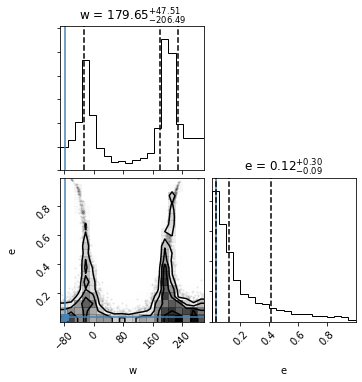

In [26]:
es_best = []
ws_best = []

print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(1):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    
    dr = 'e_' + str(e_rand[j]) + '_w_' + str(w_rand[j])
    os.mkdir('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots/' + dr + '/')
    direct = '/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots/' + dr + '/'
    
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])
    try:
        es_best_c, bestw, g = photo_fit(ttime, tflux, tflux_err, rho_star, e_rand[j], w_rand[j], direct, nsteps=6000, plot_transit=True, plot_burnin=True, fitter="MCMC") 
        es_best.append(es_best_c)
        ws_best.append(bestw)
        print("Best e: ", es_best_c)
        print("Best g: ", g)
    except ValueError:
        es_best.append(np.nan)
        print("No Fit")


In [542]:
len(es_best)

67

In [553]:
np.savetxt('es_best.csv', es_best, delimiter=',')

In [555]:
np.savetxt('ws_best.csv', ws_best, delimiter=',')

In [556]:
np.savetxt('e_rand.csv', e_rand[0:67], delimiter=',')

In [557]:
np.savetxt('w_rand.csv', w_rand[0:67], delimiter=',')

In [560]:
erand = np.loadtxt('e_rand.csv')
wrand = np.loadtxt('w_rand.csv')
efit = np.loadtxt('es_best.csv')
wfit = np.loadtxt('ws_best.csv')

In [564]:
errs = np.abs((erand-efit)/erand)

In [588]:
errs

array([1.09612249e-01, 2.77707188e-01, 3.24760967e-02, 1.19246482e-01,
       4.10805225e-02, 6.42226043e-01, 3.16838922e-01, 2.43508115e-01,
       8.45079589e-01, 5.42086386e-02, 8.18905049e-01, 5.16023868e-03,
       4.51909869e-01, 5.25078762e-03, 4.34700252e-01, 2.38801915e-01,
       2.17174741e-01, 3.28045531e-02, 2.06283349e-01, 1.15919034e-02,
       8.01954973e-02, 1.33675850e-01, 3.14904751e-01, 1.90412000e-01,
       1.03855284e-01, 2.00530000e-01, 3.72341291e-01, 3.23728550e-01,
       5.60525504e-01, 5.17295280e-01, 1.36040711e+00, 6.87338149e+00,
       1.58868334e-01, 2.67233582e-01, 1.01972012e+00, 6.43116204e-01,
       3.74165196e-01, 1.30391148e-01, 8.62654730e+00, 8.67338486e-02,
       2.56962838e-01, 6.05146320e-01, 4.85456990e-01, 4.05607812e-01,
       5.96147313e-01, 2.48175197e-01, 3.42859740e-01, 1.02228314e-01,
       7.12646528e-01, 1.21599143e-01, 9.07150031e-03, 2.11721663e-01,
       4.49101576e-01, 4.15919705e-03, 3.30036747e-01, 4.21436476e-01,
      

In [589]:
np.where(errs>5)

(array([31, 38]),)

In [581]:
np.argmax(errs)

38

In [582]:
errs[38]

8.626547297894321

In [585]:
erand[38]

0.01230612032641587

Text(0.5, 1.0, 'Color = Percent Error')

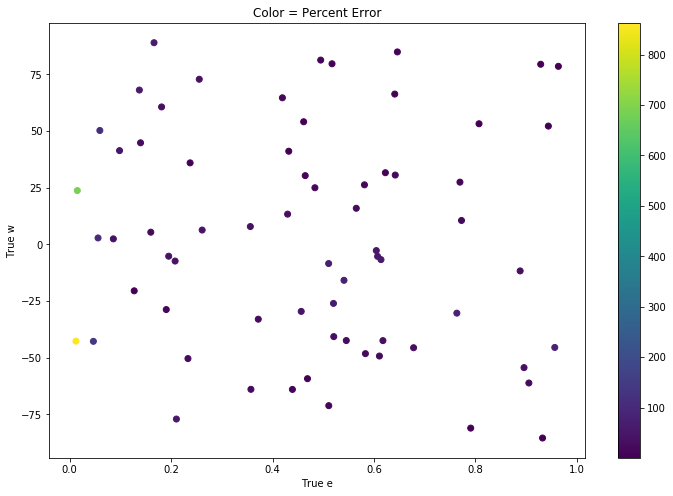

In [580]:
plt.scatter(erand, wrand, c=errs*100)
plt.colorbar()
plt.xlabel('True e')
plt.ylabel('True w')
plt.title('Color = Percent Error')

Text(0.5, 1.0, 'No Outliers ||| Color = Percent Error')

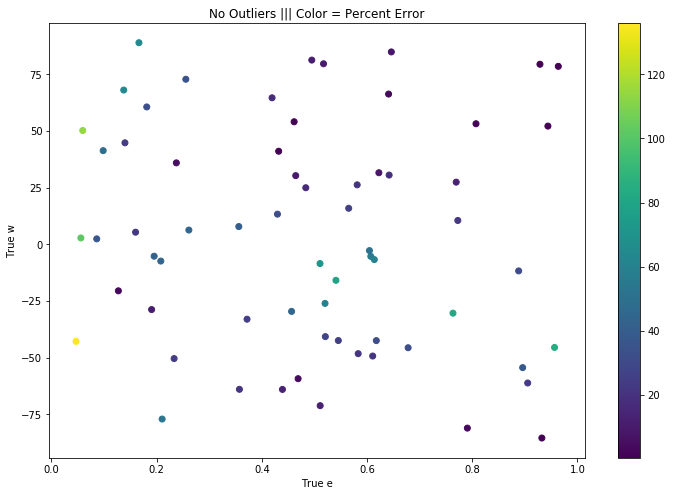

In [593]:
plt.scatter(np.delete(erand, [31, 38]), np.delete(wrand, [31,38]), c=np.delete(errs, [31,38])*100)
plt.colorbar()
plt.xlabel('True e')
plt.ylabel('True w')
plt.title('No Outliers ||| Color = Percent Error')

In [155]:
# es_best_2 = []

# print('Period (Days): ', period)
# print('Rp/Rs: ', rprs)
# print('a/Rs: ', a_rs)
# print('i (deg): ', i)

# for j in range(40):
#     print('e: ', e_rand[j], 'w: ', w_rand[j])
#     ttime = np.linspace(-24, 24, 10000)
#     tflux, tflux_err = photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j])
#     try:
#         es_best_c = photo_fit(ttime, tflux, tflux_err, rho_star, plot=True, fitter='BFGS')
#         es_best_2.append(es_best_c)
#     except ValueError:
#         es_best_2.append(np.nan)

In [156]:
# errs_2 = np.abs((e_rand[0:40]-es_best)/e_rand[0:40])

In [157]:
# plt.scatter(e_rand[0:40], w_rand[0:40], c=errs_2*100)
# plt.colorbar()
# plt.xlabel('True e')
# plt.ylabel('True w')
# plt.title('Color = Percent Error')